In [89]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from pprint import pprint
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

In [3]:
def prepare_kijkcijfers():
    start_date = datetime(2016, 1, 1)
    end_date = datetime.today()

    all_records = []

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        
        url = f"https://api.cim.be/api/cim_tv_public_results_daily_views?dateDiff={date_str}&reportType=north"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            
            data = response.json()
            records = data.get('hydra:member', [])
            
            all_records.extend(records)
        
        except Exception as e:
            print(f"Failed for date {date_str}: {e}")
        
        current_date += timedelta(days=1)

    df = pd.DataFrame(all_records)

    df['dateResult'] = pd.to_datetime(df['dateResult'])
    df['weekday'] = df['dateResult'].dt.weekday
    df['day'] = df['dateResult'].dt.day
    df['month'] = df['dateResult'].dt.month
    df['year'] = df['dateResult'].dt.year

    df['startTime'] = pd.to_datetime(df['startTime'], format='%H:%M:%S', errors='coerce')
    df['start_hour'] = df['startTime'].dt.hour
    df['start_minute'] = df['startTime'].dt.minute

    df['rLength'] = pd.to_timedelta(df['rLength'], errors='coerce')
    df['duration_seconds'] = df['rLength'].dt.total_seconds()

    df = df.drop(columns=['@id', '@type', 'reportType', 'id', 'dateImport', 'category', 'ratePerc', 'shr','rateInKAll', 'dateDiff', 'dateResult', 'startTime', 'rLength'])

    df.dropna(inplace=True)


    return df

kijkcijfers = prepare_kijkcijfers()
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63368 entries, 0 to 63498
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           63368 non-null  object 
 1   description       63368 non-null  object 
 2   channel           63368 non-null  object 
 3   rateInK           63368 non-null  object 
 4   live              63368 non-null  int64  
 5   weekday           63368 non-null  int32  
 6   day               63368 non-null  int32  
 7   month             63368 non-null  int32  
 8   year              63368 non-null  int32  
 9   start_hour        63368 non-null  float64
 10  start_minute      63368 non-null  float64
 11  duration_seconds  63368 non-null  float64
dtypes: float64(3), int32(4), int64(1), object(4)
memory usage: 5.3+ MB


In [4]:
kijkcijfers2 = kijkcijfers

In [5]:
kijkcijfers['rateInK'] = pd.to_numeric(
    kijkcijfers['rateInK']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False),
    errors='coerce'  # Invalid values become NaN
)

In [6]:
kijkcijfers['channel'] = kijkcijfers['channel'].astype("string")
kijkcijfers['description'] = kijkcijfers['description'].astype("string")

In [7]:
kijkcijfers['ranking'] = kijkcijfers['ranking'].astype(int)

In [8]:
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63368 entries, 0 to 63498
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           63368 non-null  int64  
 1   description       63368 non-null  string 
 2   channel           63368 non-null  string 
 3   rateInK           63368 non-null  float64
 4   live              63368 non-null  int64  
 5   weekday           63368 non-null  int32  
 6   day               63368 non-null  int32  
 7   month             63368 non-null  int32  
 8   year              63368 non-null  int32  
 9   start_hour        63368 non-null  float64
 10  start_minute      63368 non-null  float64
 11  duration_seconds  63368 non-null  float64
dtypes: float64(4), int32(4), int64(2), string(2)
memory usage: 5.3 MB


In [9]:
kijkcijfers = kijkcijfers[kijkcijfers['rateInK'].notna()]
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63368 entries, 0 to 63498
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           63368 non-null  int64  
 1   description       63368 non-null  string 
 2   channel           63368 non-null  string 
 3   rateInK           63368 non-null  float64
 4   live              63368 non-null  int64  
 5   weekday           63368 non-null  int32  
 6   day               63368 non-null  int32  
 7   month             63368 non-null  int32  
 8   year              63368 non-null  int32  
 9   start_hour        63368 non-null  float64
 10  start_minute      63368 non-null  float64
 11  duration_seconds  63368 non-null  float64
dtypes: float64(4), int32(4), int64(2), string(2)
memory usage: 5.3 MB


In [10]:
kijkcijfers.head(30)

,ranking,description,channel,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
0,1,HET 7 UUR-JOURNAAL,EEN,721850.0,0,5,1,10,2016,19.0,0.0,1898.0
1,2,FC DE KAMPIOENEN,EEN,709606.0,0,5,1,10,2016,20.0,41.0,2319.0
2,3,WEG ZIJN WIJ,EEN,548239.0,0,5,1,10,2016,20.0,13.0,1484.0
3,4,IEDEREEN BEROEMD,EEN,523610.0,0,5,1,10,2016,19.0,38.0,1741.0
4,5,COMEDY TOPPERS,VTM,496216.0,0,5,1,10,2016,19.0,52.0,1480.0
5,6,THE FUGITIVE,EEN,447427.0,0,5,1,10,2016,21.0,22.0,7285.0
6,7,NIEUWS 19U VTM,VTM,424041.0,0,5,1,10,2016,18.0,59.0,2547.0
7,8,HET 1 UUR-JOURNAAL,EEN,369066.0,0,5,1,10,2016,13.0,0.0,1368.0
8,9,WIELRENNEN. RONDE VAN LOMBARDIJE,EEN,368549.0,0,5,1,10,2016,14.0,29.0,10550.0
9,10,STADION,VTM,360544.0,0,5,1,10,2016,22.0,57.0,2690.0


In [11]:
kijkcijfers.describe()

,ranking,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
count,63368.000000,6.336800e+04,63368.000000,63368.000000,63368.000000,63368.000000,63368.000000,63368.000000,63368.000000,63368.000000
mean,10.576316,4.442012e+05,3.481694,3.002762,15.686040,6.469148,2020.592255,18.621370,28.038789,2682.872428
std,5.837391,2.769299e+05,8.235776,2.001753,8.791833,3.498160,2.515408,2.887184,19.921058,1757.850132
min,1.000000,1.588700e+04,0.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,0.000000,900.000000
25%,6.000000,2.290310e+05,0.000000,1.000000,8.000000,3.000000,2018.000000,18.000000,10.000000,1567.000000
50%,11.000000,3.584585e+05,0.000000,3.000000,16.000000,6.000000,2021.000000,19.000000,30.000000,2363.000000
75%,16.000000,6.030505e+05,0.000000,5.000000,23.000000,10.000000,2023.000000,20.000000,44.000000,3063.000000
max,38.000000,2.494114e+06,28.000000,6.000000,31.000000,12.000000,2025.000000,23.000000,59.000000,35359.000000


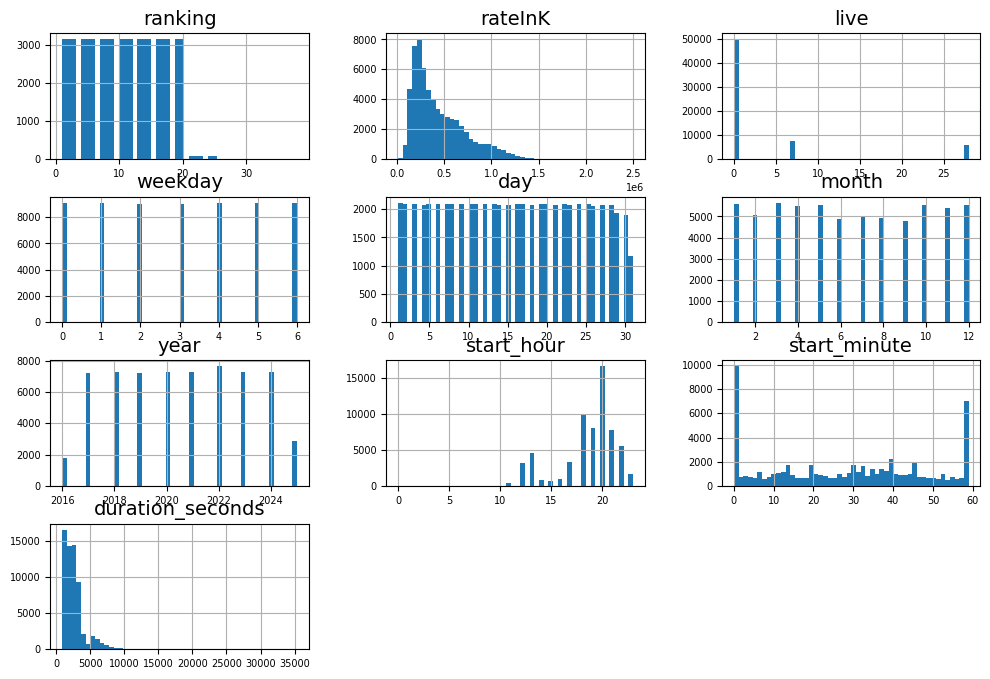

In [12]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

kijkcijfers.hist(bins=50, figsize=(12, 8))
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(kijkcijfers, test_size=0.2, random_state=42)

In [14]:
len(train_set)

50694

In [15]:
len(test_set)

12674

In [16]:
train_set.head()

,ranking,description,channel,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
51573,15,DE RECHTBANK,PLAY4,181392.0,7,5,7,10,2023,20.0,5.0,2218.0
51708,10,EXPEDITIE PAIRI DAIZA,VTM,298837.0,7,5,14,10,2023,19.0,55.0,1558.0
33909,1,THUIS,EEN,1235435.0,0,2,26,5,2021,20.0,11.0,1430.0
3543,19,DE KLEEDKAMER,CANVAS,212494.0,0,0,27,3,2017,21.0,18.0,2879.0
1864,2,HET 7 UUR-JOURNAAL,EEN,1229894.0,0,1,3,1,2017,19.0,0.0,2497.0


In [17]:
kijkcijfers = train_set.copy()

In [18]:
corr_matrix = kijkcijfers.corr(numeric_only=True)

In [19]:
corr_matrix["rateInK"].sort_values(ascending=False)

rateInK             1.000000
start_hour          0.123712
day                -0.015840
month              -0.035576
live               -0.038778
year               -0.076681
duration_seconds   -0.095245
start_minute       -0.099794
weekday            -0.125640
ranking            -0.859145
Name: rateInK, dtype: float64

In [20]:
corr_matrix

,ranking,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
ranking,1.000000,-0.859145,-0.004159,-0.001895,-0.000100,-0.005092,0.007582,-0.073258,0.075581,0.078415
rateInK,-0.859145,1.000000,-0.038778,-0.125640,-0.015840,-0.035576,-0.076681,0.123712,-0.099794,-0.095245
live,-0.004159,-0.038778,1.000000,-0.000851,-0.001268,0.022423,0.606433,0.005154,0.006799,0.009082
weekday,-0.001895,-0.125640,-0.000851,1.000000,-0.001500,0.001094,-0.000982,-0.124681,-0.001014,0.164476
day,-0.000100,-0.015840,-0.001268,-0.001500,1.000000,0.007876,-0.004575,0.004544,-0.005936,0.001864
month,-0.005092,-0.035576,0.022423,0.001094,0.007876,1.000000,-0.149051,-0.011103,0.005741,0.013051
year,0.007582,-0.076681,0.606433,-0.000982,-0.004575,-0.149051,1.000000,-0.022937,-0.001215,0.002675
start_hour,-0.073258,0.123712,0.005154,-0.124681,0.004544,-0.011103,-0.022937,1.000000,-0.072765,-0.029658
start_minute,0.075581,-0.099794,0.006799,-0.001014,-0.005936,0.005741,-0.001215,-0.072765,1.000000,0.049021
duration_seconds,0.078415,-0.095245,0.009082,0.164476,0.001864,0.013051,0.002675,-0.029658,0.049021,1.000000


In [21]:
kijkcijfers = train_set.drop("rateInK", axis=1)
kijkcijfers_labels = train_set["rateInK"].copy()

In [63]:
X_test = test_set.drop("rateInK", axis=1)
y_test = test_set["rateInK"].copy()

In [22]:
channel_cat = kijkcijfers[["channel"]]
channel_cat.head(10)

,channel
51573,PLAY4
51708,VTM
33909,EEN
3543,CANVAS
1864,EEN
33531,VTM
48582,VRT 1
54055,VTM
39499,Canvas
15135,EEN


In [23]:
description_cat = kijkcijfers[["description"]]
description_cat.head(10)

,description
51573,DE RECHTBANK
51708,EXPEDITIE PAIRI DAIZA
33909,THUIS
3543,DE KLEEDKAMER
1864,HET 7 UUR-JOURNAAL
33531,THE VOICE VAN VLAANDEREN - LIVE
48582,IEDEREEN BEROEMD
54055,NIEUWS 13U VTM
39499,DE AFSPRAAK
15135,HET JOURNAAL LAAT


In [24]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
channel_cat_encoded = ordinal_encoder.fit_transform(channel_cat)
channel_cat_encoded[:10]

array([[12.],
       [24.],
       [ 4.],
       [ 0.],
       [ 4.],
       [24.],
       [21.],
       [24.],
       [ 2.],
       [ 4.]])

In [25]:
ordinal_encoder.categories_

[array(['CANVAS', 'CAZ', 'Canvas', 'DAZN PRO LEAGUE 1 (NL)', 'EEN',
        'EEN,VTM,PLAY4', 'ELEVEN PRO LEAGUE 1 NL', 'EUROSPORT 1 (NL)',
        'KETNET', 'LA UNE', 'OP 12', 'PLAY SPORTS OPEN', 'PLAY4', 'PLAY5',
        'PLAY6', 'Q2', 'RTL-TVI', 'TF1', 'VIER', 'VIJF', 'VITAYA', 'VRT 1',
        'VRT 1/VTM/Play4', 'VRT CANVAS', 'VTM', 'VTM GOLD', 'VTM2', 'VTM3',
        'VTM4', 'ZES'], dtype=object)]

In [26]:
description_cat_cat_encoded = ordinal_encoder.fit_transform(description_cat)
description_cat_cat_encoded[:10]

array([[ 954.],
       [1201.],
       [3471.],
       [ 908.],
       [1553.],
       [3431.],
       [1732.],
       [2351.],
       [ 817.],
       [1617.]])

In [27]:
ordinal_encoder.categories_

[array(['#HETISINGEWIKKELD', '#LIKEME', '#LIKEME IN CONCERT 2', ...,
        'ZWARE JONGENS', 'ZWEMMEN. ANTWERPEN', 'ZWEMMEN. EK.MUNCHEN (S.)'],
       shape=(5382,), dtype=object)]

In [28]:
from sklearn.preprocessing import OneHotEncoder

# Select the categorical columns
categorical_cols = kijkcijfers[['channel', 'description']]

# Optionally ensure string dtype (for consistency)
#categorical_cols = categorical_cols.astype("string")

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False to get array output

# Fit and transform
encoded_array = encoder.fit_transform(categorical_cols)

# Get the feature names (column names)
encoded_kijkcijfers = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols.columns))

# Optional: Reset index to align with original kijkcijfers (if needed)
encoded_kijkcijfers.index = kijkcijfers.index

# Concatenate with original kijkcijfers (optional)
kijkcijfers_encoded = pd.concat([kijkcijfers, encoded_kijkcijfers], axis=1)

# Drop original categorical columns if you don't need them
kijkcijfers_encoded = kijkcijfers_encoded.drop(columns=['channel', 'description'])

# Display result
print(kijkcijfers_encoded.head())

       ranking  live  weekday  day  month  year  start_hour  start_minute  \
51573       15     7        5    7     10  2023        20.0           5.0   
51708       10     7        5   14     10  2023        19.0          55.0   
33909        1     0        2   26      5  2021        20.0          11.0   
3543        19     0        0   27      3  2017        21.0          18.0   
1864         2     0        1    3      1  2017        19.0           0.0   

       duration_seconds  channel_CANVAS  ...  description_ZONDER STERREN  \
51573            2218.0             0.0  ...                         0.0   
51708            1558.0             0.0  ...                         0.0   
33909            1430.0             0.0  ...                         0.0   
3543             2879.0             1.0  ...                         0.0   
1864             2497.0             0.0  ...                         0.0   

       description_ZOO AUSTRALIE  description_ZOOKEEPER  \
51573                

In [100]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
numeric_cols = ['ranking', 'weekday', 'year', 'start_hour', 'start_minute', 'duration_seconds']  # adjust based on your kijkcijfers

scaler = StandardScaler()
scaled_data = scaler.fit_transform(kijkcijfers[numeric_cols])

# Replace or merge into kijkcijfers
kijkcijfers_scaled = kijkcijfers.copy()
kijkcijfers_scaled[numeric_cols] = scaled_data


In [101]:
kijkcijfers_scaled

,ranking,description,channel,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
51573,0.756868,DE RECHTBANK,PLAY4,7,0.996348,7,10,0.960037,0.477328,-1.153752,-0.263999
51708,-0.098495,EXPEDITIE PAIRI DAIZA,VTM,7,0.996348,14,10,0.960037,0.131177,1.357756,-0.638337
33909,-1.638148,THUIS,EEN,0,-0.502431,26,5,0.164754,0.477328,-0.852371,-0.710935
3543,1.441159,DE KLEEDKAMER,CANVAS,0,-1.501618,27,3,-1.425811,0.823479,-0.500760,0.110905
1864,-1.467076,HET 7 UUR-JOURNAAL,EEN,0,-1.002025,3,1,-1.425811,0.131177,-1.404902,-0.105757
...,...,...,...,...,...,...,...,...,...,...,...
62700,-1.467076,THUIS,VRT 1,28,-0.502431,16,4,1.755320,0.477328,-0.651450,-0.743832
38267,1.441159,STURM DER LIEBE,VTM2,0,-0.502431,29,12,0.164754,-0.561125,0.001542,0.160817
885,-1.467076,HET 7 UUR-JOURNAAL,EEN,0,-1.002025,15,11,-1.823452,0.131177,-1.404902,-0.197639
15895,-0.269567,HET 1 UUR-JOURNAAL,EEN,0,-0.502431,5,12,-1.028170,-1.945729,-1.404902,-0.590127


In [113]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature groups
numeric_features = ['ranking', 'weekday','start_hour', 'start_minute', 'duration_seconds']  # Add other numeric columns if needed
categorical_features = ['channel', 'description']

# Create transformers
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# Combine into a column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)


In [114]:
kijkcijfers_prepared = preprocessor.fit_transform(kijkcijfers)

In [115]:
kijkcijfers_prepared

array([[ 0.75686816,  0.99634813,  0.4773284 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.09849481,  0.99634813,  0.1311774 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.63814815, -0.50243146,  0.4773284 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.46707555, -1.00202465,  0.1311774 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2695674 , -0.50243146, -1.94572863, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12493037, -0.50243146,  0.82347941, ...,  0.        ,
         0.        ,  0.        ]], shape=(50694, 5417))

In [116]:
kijkcijfers_prepared.shape

(50694, 5417)

# Machine Learning Algorithms

### Linear Regression

In [117]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessor, LinearRegression())  
lin_reg.fit(kijkcijfers, kijkcijfers_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ranking', 'weekday',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('linearregression', LinearRegression())])

In [118]:
lin_reg_predictions = lin_reg.predict(X_test) # here the advantage of creating a pipeline becomes clear. 
lin_reg_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([505100.,  97900., 411800., 659900., 448500.])

In [119]:
kijkcijfers_labels.iloc[:5].values

array([ 181392.,  298837., 1235435.,  212494., 1229894.])

In [120]:
lin_reg_mae = mean_absolute_error(y_test, lin_reg_predictions)
print("LinearRegression MAE: ", lin_reg_mae)

LinearRegression MAE:  73350.47078083166


### Decision Tree Regressor

In [121]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
tree_reg.fit(kijkcijfers, kijkcijfers_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ranking', 'weekday',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [122]:
kijkcijfers_predictions = tree_reg.predict(X_test)
decission_tree_reg_mae = mean_absolute_error(y_test, kijkcijfers_predictions)

print("DecisionTreeRegressor MAE: ", decission_tree_reg_mae)

DecisionTreeRegressor MAE:  73884.79075309784


In [123]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, kijkcijfers, kijkcijfers_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [124]:
tree_rmses

array([108731.80444689, 109043.40679447, 111795.55978002, 106989.01552817,
       106165.47581145, 108474.59446776, 107747.40924546, 108715.24867145,
       111631.35097304, 113285.96671599])

In [125]:
pd.Series(tree_rmses).describe()

count        10.000000
mean     109257.983243
std        2273.559040
min      106165.475811
25%      107929.205551
50%      108723.526559
75%      110984.364928
max      113285.966716
dtype: float64

In [126]:
lin_rmses = -cross_val_score(lin_reg, kijkcijfers, kijkcijfers_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count        10.000000
mean     107456.422962
std        2965.354825
min      103471.493989
25%      104886.142428
50%      107558.915846
75%      109544.632043
max      112420.718502
dtype: float64

### Random Forest Regressor

In [127]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessor,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, kijkcijfers, kijkcijfers_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [128]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     86251.634143
std       1372.489262
min      84248.303695
25%      85364.839758
50%      86335.493478
75%      87028.612666
max      88837.530254
dtype: float64

In [129]:
forest_reg.fit(kijkcijfers, kijkcijfers_labels)
kijkcijfers_predictions = forest_reg.predict(X_test)
randrom_forest_reg_mae = mean_absolute_error(y_test, kijkcijfers_predictions)
print("RandomForestRegressor MAE: ", decission_tree_reg_mae)

RandomForestRegressor MAE:  73884.79075309784


In [130]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                           RandomForestRegressor(random_state=42))
param_grid = [
    # try 9 (3×3) combinations of hyperparameters with bootstrap set as True (default)
    {'randomforestregressor__n_estimators': [50,100,200], 
     'randomforestregressor__max_features': [4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'randomforestregressor__bootstrap': [False],
     'randomforestregressor__n_estimators': [50,100],
     'randomforestregressor__max_features': [3, 4, 6]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(kijkcijfers, kijkcijfers_labels)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_features': 6,
 'randomforestregressor__n_estimators': 100}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['live', 'ranking', 'weekday',
                                                   'day', 'month', 'year',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_features=6,
                                       random_state=42))])

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

74977.56586342344 {'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 50}
73795.13003317152 {'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 100}
73305.97179392765 {'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 200}
74063.25680484784 {'randomforestregressor__max_features': 6, 'randomforestregressor__n_estimators': 50}
73346.86386703477 {'randomforestregressor__max_features': 6, 'randomforestregressor__n_estimators': 100}
73221.55684886331 {'randomforestregressor__max_features': 6, 'randomforestregressor__n_estimators': 200}
74261.10159124945 {'randomforestregressor__max_features': 8, 'randomforestregressor__n_estimators': 50}
72756.3305381387 {'randomforestregressor__max_features': 8, 'randomforestregressor__n_estimators': 100}
72066.77025472333 {'randomforestregressor__max_features': 8, 'randomforestregressor__n_estimators': 200}
72825.27681487164 {'randomforestregressor__bootstrap': Fals

In [ ]:
best_forest_reg = grid_search.best_estimator_

pred = best_forest_reg.predict(X_test)  # the same transformations will be executed on the test set!

forest_reg_rmse = root_mean_squared_error(y_test, pred)
forest_reg_mae = mean_absolute_error(y_test, pred)
print(forest_reg_rmse)
print("RandomForrestRegression GridSearch MAE:", forest_reg_mae)

67526.6578636072
RandomForrestRegression GridSearch MAE: 44086.97470285625


### Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

# Build pipeline (reusing your preprocessor)
lasso_pipeline = make_pipeline(preprocessor, Lasso(alpha=0.1))

# Fit on training data
lasso_pipeline.fit(kijkcijfers, kijkcijfers_labels)

# Predict and evaluate
y_pred = lasso_pipeline.predict(X_test)
lasso_mae = mean_absolute_error(y_test, y_pred)

print("Lasso MAE:", lasso_mae)

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.535e+13, tolerance: 3.913e+11
  model = cd_fast.enet_coordinate_descent(


Lasso MAE: 71118.13994393774


### Ridge

In [ ]:
from sklearn.linear_model import Ridge

# Create a pipeline with the same preprocessor and Ridge regression
ridge_pipeline = make_pipeline(preprocessor, Ridge(alpha=1.0))

# Fit the model on training data
ridge_pipeline.fit(kijkcijfers, kijkcijfers_labels)

# Predict on the test set
y_pred = ridge_pipeline.predict(X_test)

# Evaluate using MAE or another metric
ridge_mae = mean_absolute_error(y_test, y_pred)

print("Ridge MAE:", ridge_mae)

Ridge MAE: 70869.67955277945


### SVR Linear

In [ ]:
from sklearn.svm import LinearSVR

# 1. Create the full pipeline
svm_pipeline = make_pipeline(
    preprocessor,
    LinearSVR(random_state=42, max_iter=10000)
)

# 2. Define the hyperparameter grid with correct names
linear_svr_params = {
    "linearsvr__epsilon": [0.1, 0.5, 1.0, 1.5, 2.0],
    "linearsvr__C": [0.1, 1.0, 10.0, 100.0],
    "linearsvr__loss": ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

# 3. Grid search
grid_search_LSVR = GridSearchCV(
    svm_pipeline,
    linear_svr_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

# 4. Fit on training data
grid_search_LSVR.fit(kijkcijfers, kijkcijfers_labels)

# 5. Predict on test data
best_svm = grid_search_LSVR.best_estimator_
y_pred = best_svm.predict(X_test)

# 6. Evaluate
svm_lin_mae = mean_absolute_error(y_test, y_pred)
print("Best LinearSVR MAE:", svm_lin_mae)

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
91 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Best LinearSVR MAE: 435511.5459996838
